----

---

# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [50]:
# Cargar todas las librerías
from scipy import stats as st
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## Cargar datos

In [51]:
# Carga los archivos de datos en diferentes DataFrames

calls = pd.read_csv("/datasets/megaline_calls.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
users = pd.read_csv("/datasets/megaline_users.csv")


## Preparar los datos

In [52]:
calls.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [53]:
internet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [54]:
messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [55]:
plans.info(show_counts=True)
print(plans.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10           

In [56]:
users.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [57]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

plans.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [58]:
# Imprime una muestra de los datos para las tarifas

print(plans.head(9))



   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


In [59]:
plans.duplicated().sum()

0

Como primer analisis, hay varias columnas en este df pero da la sensación que estan vacias porque al imprimir una muestra solo aparecen dos filas. Se debería tener una misma unidad de medida para los MB y GB porque hay dos columnas que lo toman como referencia

## Usuarios/as

In [130]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

users.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
 8   state       500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 35.3+ KB


In [131]:
# Imprime una muestra de datos para usuarios

print(users.head(10))



   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

    reg_date      plan  churn_date                                      state  
0 2018-12-24  ultimate     c

Veo dos cosas. La primera es que lo valores ausentes deden de ser reemplazados por algo mejor representativo debido a que si aparece Nan, significa que el plan sigue activo al momento de hacer el df. 

### Corregir los datos

In [62]:
users["churn_date"] = users["churn_date"].fillna("current")
users["reg_date"] = pd.to_datetime(users["reg_date"], format="%Y-%m-%d")

## Llamadas

In [63]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

calls.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [64]:
# Imprime una muestra de datos para las llamadas

print(calls.head(10))


         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
5  1000_388     1000  2018-12-31      2.20
6  1000_510     1000  2018-12-27      5.75
7  1000_521     1000  2018-12-28     14.18
8  1000_530     1000  2018-12-28      5.77
9  1000_544     1000  2018-12-26      4.40


call_date no está en el formato correcto, hay que corregirlo puesto que es una fecha. Lo mismo para user_id porque tiene que ser un str. 

### Corregir los datos

In [65]:
calls["call_date"] = pd.to_datetime(calls["call_date"], format="%Y-%m-%d")


## Mensajes

In [66]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [67]:
# Imprime una muestra de datos para los mensajes

print(messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


El mismo error se repite, el formato de message_date no es correcto debido a que tiene una fecha y se considera como un numero, por el momento 

### Corregir los datos

In [68]:
messages["message_date"] = pd.to_datetime(messages["message_date"], format="%Y-%m-%d")

## Internet

In [69]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [70]:
# Imprime una muestra de datos para el tráfico de internet

print(internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


La columna session_date se considera como numero entero, pero tiene fechas

### Corregir los datos

In [71]:
internet["session_date"] = pd.to_datetime(internet["session_date"], format="%Y-%m-%d")

## Estudiar las condiciones de las tarifas

In [72]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

print(plans.head())


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [73]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

calls["month"] = calls["call_date"].dt.month

calls_per_user = calls.groupby(["user_id", "month"])["duration"].count().reset_index()
print(calls_per_user.head())



   user_id  month  duration
0     1000     12        16
1     1001      8        27
2     1001      9        49
3     1001     10        65
4     1001     11        64


In [74]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

calls["rounded_duration"] = np.ceil(calls["duration"])
minutes_per_user = calls.groupby(["user_id", "month"])["rounded_duration"].sum().reset_index()
print(minutes_per_user.head())


   user_id  month  rounded_duration
0     1000     12             124.0
1     1001      8             182.0
2     1001      9             315.0
3     1001     10             393.0
4     1001     11             426.0


In [75]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

messages["month"] = messages["message_date"].dt.month
messages_per_user = messages.groupby(["user_id", "month"])["id"].count().reset_index()
print(messages_per_user.head())

   user_id  month  id
0     1000     12  11
1     1001      8  30
2     1001      9  44
3     1001     10  53
4     1001     11  36


In [76]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

internet["month"] = internet["session_date"].dt.month
internet["rounded_int"] = np.ceil(internet["mb_used"])
internet_per_user = internet.groupby(["user_id", "month"])["rounded_int"].sum().reset_index()
print(internet_per_user.head())

   user_id  month  rounded_int
0     1000     12       1903.0
1     1001      8       6929.0
2     1001      9      13333.0
3     1001     10      22356.0
4     1001     11      18524.0


In [132]:
df_user = users[["user_id", "plan", "city"]]

In [133]:
print(calls_per_user["user_id"].dtype)
print(users["user_id"].dtype)

int64
int64


In [134]:
users["user_id"] = users["user_id"].astype(int)

In [135]:
print(calls_per_user["user_id"].dtype)
print(users["user_id"].dtype)

int64
int64


In [136]:
print(messages_per_user.columns)
print(minutes_per_user.columns)
print(internet_per_user.columns)
print(calls_per_user.columns)

Index(['user_id', 'month', 'id'], dtype='object')
Index(['user_id', 'month', 'rounded_duration'], dtype='object')
Index(['user_id', 'month', 'rounded_int'], dtype='object')
Index(['user_id', 'month', 'duration'], dtype='object')


In [137]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
calls_per_user_df = calls_per_user.merge(df_user, on="user_id", how="left")
messages_per_user_df = calls_per_user_df.merge(messages_per_user, on=["user_id", "month"], how="left")
minutes_per_user_df = messages_per_user_df.merge(minutes_per_user, on=["user_id", "month"], how="left")
complete_df = minutes_per_user_df.merge(internet_per_user, on=["user_id", "month"], how="left")


In [138]:
print(complete_df)

      user_id  month  duration      plan  \
0        1000     12        16  ultimate   
1        1001      8        27      surf   
2        1001      9        49      surf   
3        1001     10        65      surf   
4        1001     11        64      surf   
...       ...    ...       ...       ...   
2253     1498     12        39      surf   
2254     1499      9        41      surf   
2255     1499     10        53      surf   
2256     1499     11        45      surf   
2257     1499     12        65      surf   

                                           city    id  rounded_duration  \
0         Atlanta-Sandy Springs-Roswell, GA MSA  11.0             124.0   
1               Seattle-Tacoma-Bellevue, WA MSA  30.0             182.0   
2               Seattle-Tacoma-Bellevue, WA MSA  44.0             315.0   
3               Seattle-Tacoma-Bellevue, WA MSA  53.0             393.0   
4               Seattle-Tacoma-Bellevue, WA MSA  36.0             426.0   
...                  

In [139]:
# Añade la información de la tarifa

plans["plan"] = plans["plan_name"]

complete_df_plans = complete_df.merge(plans, on="plan", how="left")
complete_df_plans = complete_df.merge(plans, on="plan", how="left")

In [140]:
print(plans.columns)

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name', 'plan'],
      dtype='object')


In [141]:
print(complete_df_plans.head())

   user_id  month  duration      plan                                   city  \
0     1000     12        16  ultimate  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001      8        27      surf        Seattle-Tacoma-Bellevue, WA MSA   
2     1001      9        49      surf        Seattle-Tacoma-Bellevue, WA MSA   
3     1001     10        65      surf        Seattle-Tacoma-Bellevue, WA MSA   
4     1001     11        64      surf        Seattle-Tacoma-Bellevue, WA MSA   

     id  rounded_duration  rounded_int  messages_included  \
0  11.0             124.0       1903.0               1000   
1  30.0             182.0       6929.0                 50   
2  44.0             315.0      13333.0                 50   
3  53.0             393.0      22356.0                 50   
4  36.0             426.0      18524.0                 50   

   mb_per_month_included  minutes_included  usd_monthly_pay  usd_per_gb  \
0                  30720              3000               70           7   
1 

In [142]:
# Calcula el ingreso mensual para cada usuario

# MB a GB para el calculo de excedente
complete_df_plans["gb_used"] = complete_df_plans["rounded_int"] / 1024


#Calcular excedentes 
complete_df_plans["extra_minutes"] = (complete_df_plans["duration"] - complete_df_plans["minutes_included"]).clip(lower=0)
complete_df_plans["extra_messages"] = (complete_df_plans["id"] - complete_df_plans["messages_included"]).clip(lower=0)
complete_df_plans["extra_gb"] = (complete_df_plans["gb_used"] - complete_df_plans["mb_per_month_included"] / 1024).clip(lower=0)



In [143]:
# Costos adicionales 

complete_df_plans["extra_minutes_cost"] = complete_df_plans["extra_minutes"] * complete_df_plans["usd_per_minute"]
complete_df_plans["extra_message_cost"] = complete_df_plans["extra_messages"] * complete_df_plans["usd_per_message"]
complete_df_plans["extra_gb_cost"] = complete_df_plans["extra_gb"] * complete_df_plans["usd_per_gb"]

#Total mensual

complete_df_plans["revenue"] = (
    complete_df_plans["usd_monthly_pay"] + 
    complete_df_plans["extra_minutes_cost"] + 
    complete_df_plans["extra_message_cost"] + 
    complete_df_plans["extra_gb_cost"])



In [144]:
complete_df_plans[["user_id", "month", "plan", "revenue"]].head()

,user_id,month,plan,revenue
0,1000,12,ultimate,70.000000
1,1001,8,surf,20.000000
2,1001,9,surf,20.000000
3,1001,10,surf,88.410313
4,1001,11,surf,50.898438


In [145]:
complete_df_plans_clean = complete_df_plans.dropna()

print(complete_df_plans_clean)


      user_id  month  duration      plan  \
0        1000     12        16  ultimate   
1        1001      8        27      surf   
2        1001      9        49      surf   
3        1001     10        65      surf   
4        1001     11        64      surf   
...       ...    ...       ...       ...   
2238     1496      9        52      surf   
2239     1496     10        46      surf   
2240     1496     11        39      surf   
2241     1496     12        40      surf   
2242     1497     12        54  ultimate   

                                        city    id  rounded_duration  \
0      Atlanta-Sandy Springs-Roswell, GA MSA  11.0             124.0   
1            Seattle-Tacoma-Bellevue, WA MSA  30.0             182.0   
2            Seattle-Tacoma-Bellevue, WA MSA  44.0             315.0   
3            Seattle-Tacoma-Bellevue, WA MSA  53.0             393.0   
4            Seattle-Tacoma-Bellevue, WA MSA  36.0             426.0   
...                                    

## Estudia el comportamiento de usuario

### Llamadas

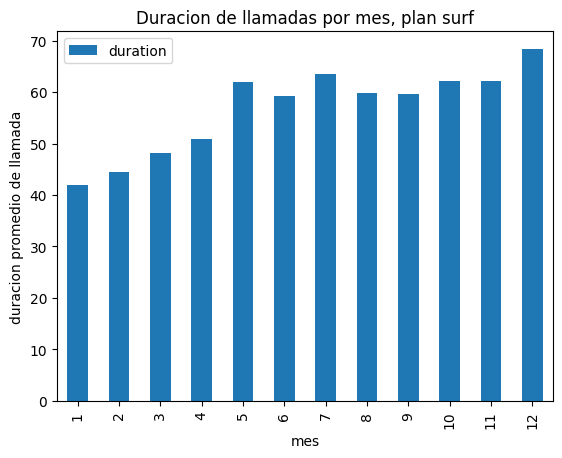

In [146]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

avg_duration_surf = complete_df_plans_clean[complete_df_plans_clean["plan"] == "surf"].groupby("month")["duration"].mean().reset_index()

avg_duration_surf.plot(kind="bar",
                     x="month", 
                     y="duration",
                     xlabel="mes",
                     ylabel="duracion promedio de llamada",
                     title="Duracion de llamadas por mes, plan surf")
plt.show()
                        

<AxesSubplot:title={'center':'Duracion de llamadas por mes, plan ultimate'}, xlabel='mes', ylabel='duracion promedio de llamada'>

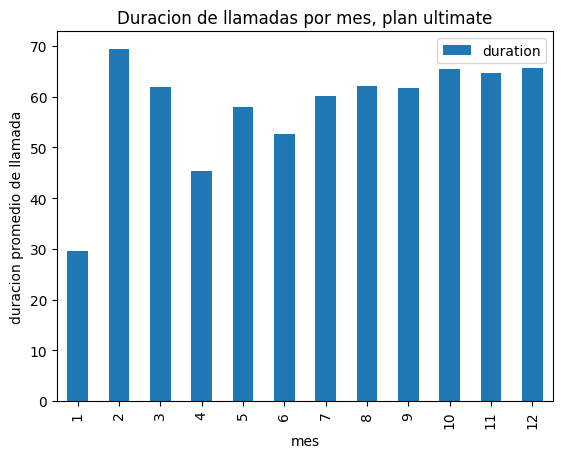

In [147]:
avg_duration_ultimate = complete_df_plans_clean[complete_df_plans_clean["plan"] == "ultimate"].groupby("month")["duration"].mean().reset_index()


avg_duration_ultimate.plot(kind="bar",
                     x="month", 
                     y="duration",
                     xlabel="mes",
                     ylabel="duracion promedio de llamada",
                     title="Duracion de llamadas por mes, plan ultimate")

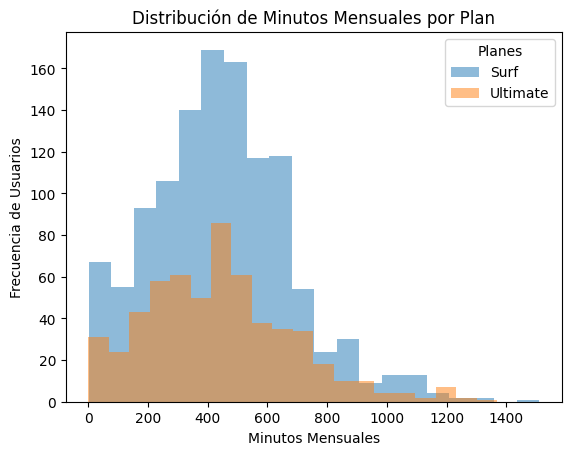

In [148]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

complete_df_plans_clean[complete_df_plans_clean['plan'] == 'surf']['rounded_duration'].plot(kind='hist', alpha=0.5, label='Surf', bins=20)
complete_df_plans_clean[complete_df_plans_clean['plan'] == 'ultimate']['rounded_duration'].plot(kind='hist', alpha=0.5, label='Ultimate', bins=20)


plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia de Usuarios')
plt.title('Distribución de Minutos Mensuales por Plan')
plt.legend(title="Planes")
plt.show()


In [149]:
# Calcula la media y la varianza de la duración mensual de llamadas.

call_stats = complete_df_plans_clean.groupby("plan")["duration"].mean()

variance = np.var(call_stats)

print("La media de la duracion mensual de llamadas es:", call_stats)
print("La varianza de la duracion mensual de llamadas es:", variance)


La media de la duracion mensual de llamadas es: plan
surf        62.196610
ultimate    62.286701
Name: duration, dtype: float64
La varianza de la duracion mensual de llamadas es: 0.0020290988490734136


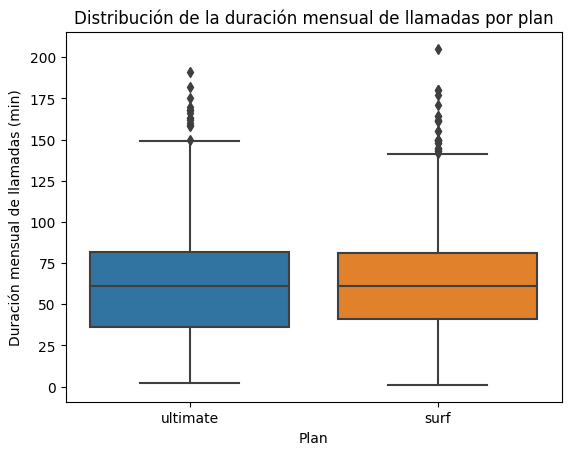

In [150]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

sns.boxplot(data=complete_df_plans_clean, x="plan", y="duration")
plt.title("Distribución de la duración mensual de llamadas por plan")
plt.xlabel("Plan")
plt.ylabel("Duración mensual de llamadas (min)")
plt.show()

La media de minutos por plan es casi similar. Se puede observar que la media de ultimate es 400 min y la de surf es 425 min. De igual manera, el valos maximo para ambos es 1000 min por llamada, aunque se tiene un sesgo hacia la derecha 

### Mensajes

In [151]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

avg_messages_by_plan = complete_df_plans_clean.groupby("plan")["id"].mean().reset_index()

print(avg_messages_by_plan)

       plan         id
0      surf  39.489831
1  ultimate  46.455959


In [152]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

avg_internet_by_plan = complete_df_plans_clean.groupby("plan")["rounded_int"].mean().reset_index()

print(avg_internet_by_plan)

       plan   rounded_int
0      surf  16648.568644
1  ultimate  17270.944732


En promedio, los usuarios del plan ultimate envian el mayor numero de mensajes de texto al mes. De igual forma, consumen la mayor cantidad de mb al mes. Esto es en comparacion a los usuarios del plan surf 

### Internet

Text(0, 0.5, 'MB usados por mes')

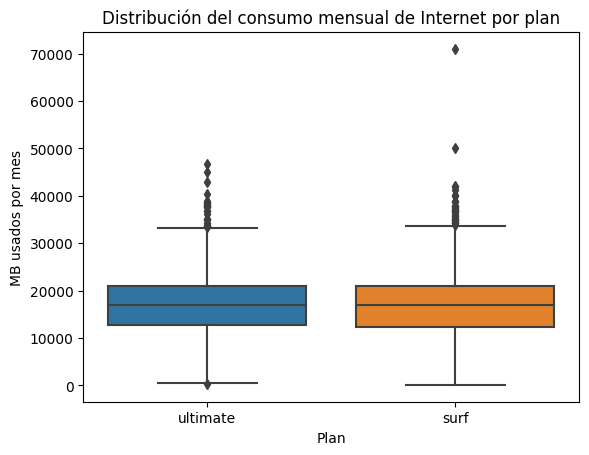

In [153]:
sns.boxplot(data=complete_df_plans_clean, x="plan", y="rounded_int")
plt.title("Distribución del consumo mensual de Internet por plan")
plt.xlabel("Plan")
plt.ylabel("MB usados por mes")

La media de MB usados por plan es muy similar, la de ultimate esta en casi 20000 MB por mes y la de surf en 19000 MB por mes. Por otro lado, el 75% de los datos no superan los 25000, los datos estan muy concentrados entre el Q1 y Q3. 

## Ingreso

Text(0, 0.5, 'Ingreso')

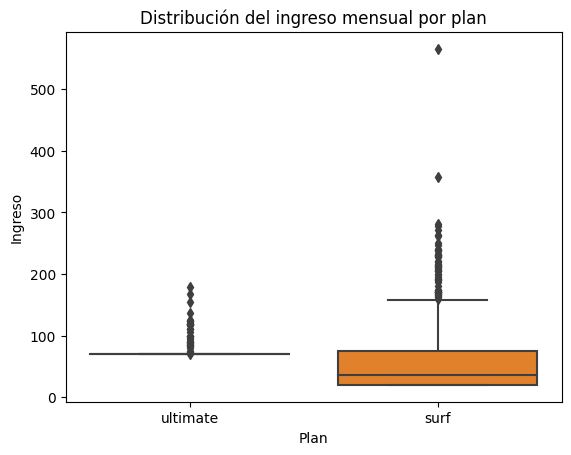

In [156]:
sns.boxplot(data=complete_df_plans_clean, x="plan", y="revenue")
plt.title("Distribución del ingreso mensual por plan")
plt.xlabel("Plan")
plt.ylabel("Ingreso")

El ingreso para el plan surf es mayor de acuerdo a la media. Esto pueda dar a entender que los beneficios que incluye no son suficientes y por ende, los usuarios terminan pagando de mas cada mes. Esto de puede comprobar por el sesgo hacia la derecha que existe y los datos anomarmales que hay en surf

## Prueba las hipótesis estadísticas

c

Hipotesis nula: los ingresos promedio de los planes no son diferentes 
Hipotesis alternativa: los ingresos promedio de los planes son diferentes 

In [125]:
# Prueba las hipótesis
surf_revenue = complete_df_plans_clean[complete_df_plans_clean["plan"] == "surf"]["revenue"]
ultimate_revenue = complete_df_plans_clean[complete_df_plans_clean["plan"] == "ultimate"]["revenue"]

alpha = 0.05 

result = st.ttest_ind(surf_revenue, ultimate_revenue)

print('valor p:', result.pvalue)

if (result.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 1.1667834288194866e-14
Rechazamos la hipótesis nula


In [155]:
# Prueba las hipótesis
ny_nj_users = complete_df_plans[complete_df_plans["city"].isin(["NY", "NJ"])]["revenue"]
other_users = complete_df_plans[~complete_df_plans["city"].isin(["NY", "NJ"])]["revenue"]

alpha = 0.05 

restult = st.ttest_ind(ny_nj_users, other_users)

print('valor p:', result.pvalue)

if (result.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 1.1667834288194866e-14
Rechazamos la hipótesis nula


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

Por el momento no se puede rechazar la hipotesis nula debido a que el valor p es menor al 5% 

Tengo una duda, y tambien es la razon de que no he escrito la conclusion. El hist de revenue cambio, supongo que la razon es porque elimine los Nan del DF. 